# Bike-Sharing and Transportation

### Overview
In this report, I will show that probably most of the clients of the bike-sharing busnisses use the bikes as a transportation to go to thier work or school and most of them are regular subscribers. The main focus will be on the duration and the distribution of rides over days and hours.
<br>

### Dataset Overview
The dataset consists of the duration and attributes for 183412 ride covering the greater San Francisco Bay area, and the dataset only includes Febuary, 2019 rides.
The attributes that are included in the dataset are ('duration_sec', 'start_time', 'end_time', 'start_station_id','start_station_name', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type', 'member_birth_year', 'member_gender' and 'bike_share_for_all_trip')
<br>

the attributes that I included in my investgation are duration_sec, start_time, start and stop station longitude and latitude, user_type, member_birth_year and member_gender

In [1]:
# importing neccessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os 

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# change the current working directory to the notebooks's directory 
os.chdir(os.path.dirname(os.path.realpath('__file__')))
# load the dataset
bikeshare = pd.read_csv("201902-fordgobike-tripdata.csv")

In [2]:
def get_distance(long1, lat1, long2, lat2):
    """ returns the distance between two
    locations given the lat and long of them

    Args:
        long1 (float): first location longitude
        lat1 (float): first location latitude
        long2 (float): second location longitude
        lat2 (float): second location latitude

    Returns:
        d (float): the distance between the two locations in KM
    """
    radius = 6371 # the raduis of the earth
    dlat = np.radians(np.abs(lat1-lat2))
    dlong = np.radians(np.abs(long1-long2))
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlong / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = radius * c
    return d

In [3]:
# generate the distance variable 
bikeshare['distance'] = get_distance(bikeshare.start_station_longitude,
                                     bikeshare.start_station_latitude,
                                     bikeshare.end_station_longitude,
                                     bikeshare.end_station_latitude) * 1e3
# generate the age variable
bikeshare['age'] = 2019 - bikeshare.member_birth_year

# convert start and end time to be in datetime format
# and convert ids to str
bikeshare = bikeshare.astype({'start_time': np.Datetime64,
                              'end_time': np.Datetime64,
                              'start_station_id': str,
                              'end_station_id': str})

for col in ['start_station_id', 'end_station_id']:
    bikeshare[col] = bikeshare[col].apply(lambda x: x.split('.')[0])

# generate the weekday column 
bikeshare['weekday'] = bikeshare.start_time.dt.day_name()

# create a new dataframe with outliers excluded
major_bikeshare = bikeshare.query('duration_sec < 4000')

## The Distribution of Duration Variable
The duration variable represents how long the ride have been in seconds. Most of the rides took around 10 to 32 mins.

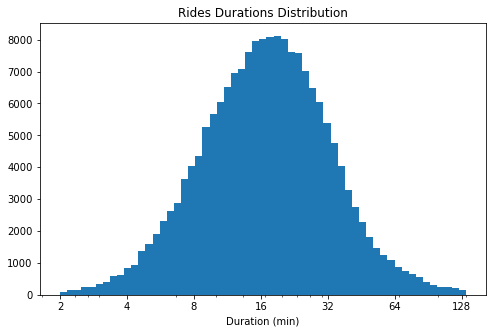

In [4]:

log_binsize = 0.032
binedges = 10 ** np.arange(np.log10(60), np.log10(major_bikeshare['duration_sec'].max())+log_binsize, log_binsize)
ticks = [60 * 2 ** i for i in range(7)]
labels = [f"{2 ** i}" for i in range(1, 8)]

plt.figure(figsize=[8, 5])
plt.hist(data = major_bikeshare, x='duration_sec', bins=binedges)
plt.title("Rides Durations Distribution")
plt.xscale('log')
plt.xticks(ticks, labels)
plt.xlabel('Duration (min)');

## The Distribution of Distance Variable
The Distance variable represents the difference between the start and end stations takes in kilometers. Most of the rides were between 1 and 3 kilometers.

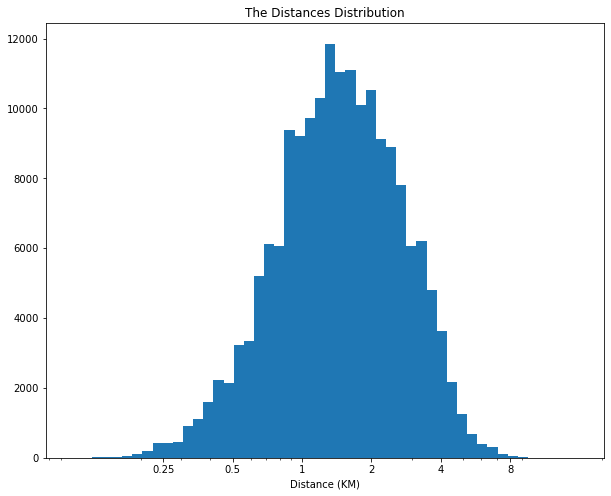

In [5]:
log_binsize = 0.044
binedges = 10 ** np.arange(2, np.log10(major_bikeshare.distance.max())+log_binsize, log_binsize)
ticks = [250 * 2 ** i for i in range(6)]
labels = [0.25, 0.5, 1, 2, 4, 8]
plt.figure(figsize=[10, 8])
plt.title("The Distances Distribution")
plt.xscale('log')
plt.hist(data=major_bikeshare, x='distance', bins=binedges)
plt.xlabel('Distance (KM)')
plt.xticks(ticks, labels);

## The Frequency of Rides over Weekdays
work days have higher number of rides.

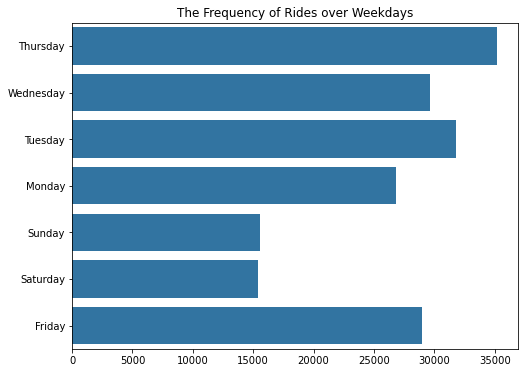

In [6]:
base_color = sns.color_palette()[0]

plt.figure(figsize=[8, 6])
sns.countplot(data=bikeshare, y='weekday', color=base_color)
plt.title('The Frequency of Rides over Weekdays')
plt.xlabel('')
plt.ylabel('');

## Weekdays and user types and gender
it appers that the number of customers isn't affected by the day, in contrast subscribers are more common to ride in working days.

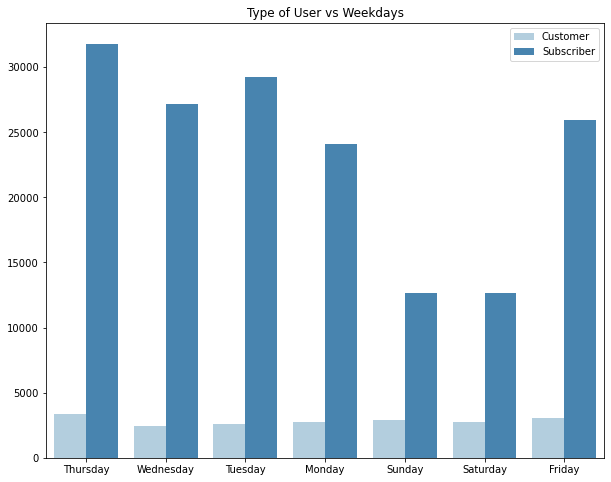

In [7]:
plt.figure(figsize=[10, 8])
sns.countplot(data=bikeshare, hue='user_type', x='weekday', palette='Blues')
plt.title('Type of User vs Weekdays')
plt.xlabel('')
plt.ylabel('')
plt.legend(loc='upper right', title='');

## Day Hours vs Weekday
- The distribution of rides over the hours of day is bimodal for all working days with one peak between 7 and 9 AM and another peak between 4 and 6 PM
- It transforms to unimodal for weekends with one spike between 12 and 5 pm.
- Therefore the most frequant rides are on working days, the most frequent hours are when workers go and come back from their work. 

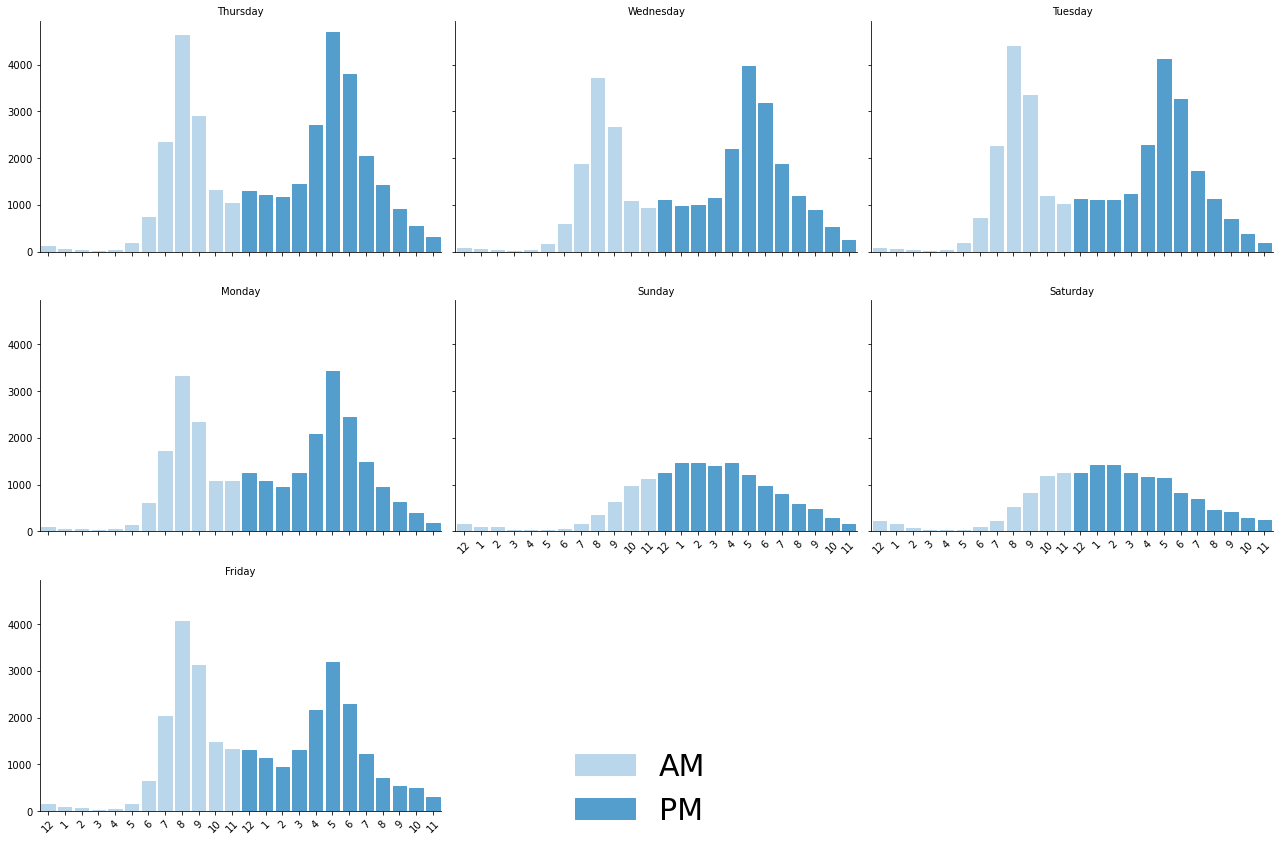

In [8]:
def plt_day_dist(x, **kwargs):
    base_colors = sns.color_palette('Blues')
    ticks = np.arange(0, 24)
    color = 12 * [base_colors[1]] + 12 * [base_colors[3]]
    labels = ['12'] + [f"{i}" for i in range(1, 12)]
    labels = labels * 2
    ax = sns.countplot(x=x.dt.hour)
    ax.set_xlabel('Number of rides')
    ax.set_xticks(ticks=ticks, labels=labels, rotation=45)
    ax.set_ylabel('')
    for p,c in zip(ax.patches, color):
        p.set_color(c)
    
    
base_colors = sns.color_palette('Blues')
am = mpatches.Patch(color=base_colors[1], label='AM')
pm = mpatches.Patch(color=base_colors[3], label='PM')
g = sns.FacetGrid(data = major_bikeshare, col = 'weekday', col_wrap = 3, height = 4, aspect=1.5)
g.map(plt_day_dist, 'start_time')
g.set_xlabels('')
g.set_ylabels('')
g.set_titles(col_template="{col_name}")
g.add_legend(legend_data={'AM': am, 'PM': pm}, loc='lower center', fontsize=30);

## Weekdays and User Type by Duration
The average duration is higher for customers than subscribers, it also has more variation. and the avg duration in general increases on weekends.

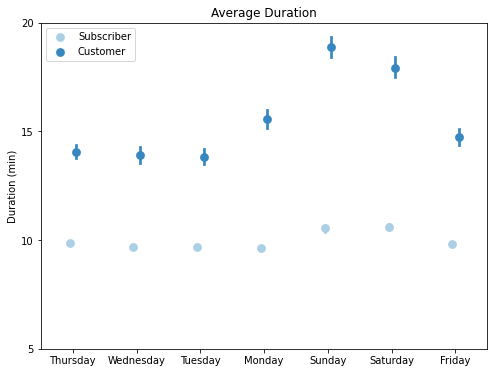

In [9]:
ticks = [i * 60 for i in range(5, 25 , 5)]
labels = [f"{i // 60}" for i in ticks]

fig = plt.figure(figsize = [8,6])
ax = sns.pointplot(data = major_bikeshare, x = 'weekday', y = 'duration_sec', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.1)

ax.set_yticks(ticks, labels)
ax.set_yticklabels([],minor = True)
ax.set_ylabel('Duration (min)')
ax.set_xlabel('')
ax.set_title('Average Duration')
ax.legend(title='');

In [ ]:
!jupyter nbconvert bike_sharing_part2.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook bike_sharing_part2.ipynb to slides
[NbConvertApp] Writing 690739 bytes to bike_sharing_part2.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/bike_sharing_part2.slides.html
Use Control-C to stop this server
